In [1]:

import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import os
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input

tf.__version__

'2.0.0'

In [2]:
print("\n".join(os.listdir("./")))
df = pd.read_csv('DJI_modified_sma.csv')

stock_can_change_our_world.ipynb
.DS_Store
saved_model
DJI_modified_features - DJI.csv
stock_can_change_our_world-sma.ipynb
DJI_modified_sma.csv
dowjone1985_2019.csv
.ipynb_checkpoints
.git


In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sma5,sma10,sma25,sma75,sma125,sma200
0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000,1292.619995,1292.619995,1292.619995,1292.619995,1292.619995,1292.619995
1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005
2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020
3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971
4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000,1287.013989,1290.079956,1290.079956,1290.079956,1290.079956,1290.079956


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,sma5,sma10,sma25,sma75,sma125,sma200
count,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8.762000e+03,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000
mean,9741.540516,9800.407342,9680.969127,9744.180560,9744.180560,1.387696e+08,9738.288319,9730.964669,9709.143362,9636.784488,9564.918578,9458.638821
std,6379.993445,6406.101221,6351.951044,6380.505213,6380.505213,1.218227e+08,6375.645973,6369.877839,6353.093276,6298.411546,6243.063416,6160.864855
min,1243.709961,1251.209961,1235.530029,1242.050049,1242.050049,2.530000e+06,1246.420020,1253.411023,1261.478818,1242.050049,1242.050049,1242.050049
25%,3614.900086,3635.000000,3595.430053,3616.775024,3616.775024,2.666250e+07,3616.110974,3611.814222,3598.590109,3561.849625,3522.914113,3460.122220
50%,9958.229981,10031.165040,9873.945312,9958.939942,9958.939942,1.047850e+08,9955.690039,9966.947461,10013.490235,10006.442710,9937.613086,9844.902081
75%,12604.689700,12672.895020,12536.984863,12608.264892,12608.264892,2.266075e+08,12590.240043,12576.958180,12560.957970,12505.968420,12464.211825,12284.940260
max,27364.689450,27398.679690,27294.169920,27359.160160,27359.160160,2.190810e+09,27293.928120,27255.588090,27026.882730,26657.372450,26448.710060,26196.764980


In [5]:
df = df.drop('Adj Close', axis=1)

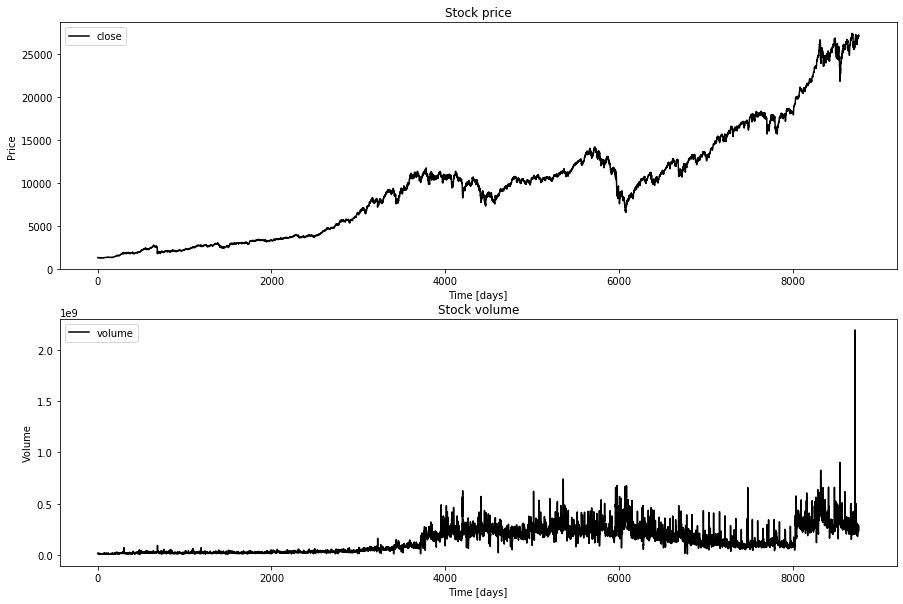

In [6]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(df['Close'], color='black', label='close')
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')


plt.subplot(2, 1, 2)
plt.plot(df['Volume'], color='black', label='volume')
plt.title('Stock volume')
plt.xlabel('Time [days]')
plt.ylabel('Volume')
plt.legend(loc='best')

In [7]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df['Open'].to_numpy().reshape(-1, 1))
    df['Low'] = min_max_scaler.fit_transform(df['Low'].to_numpy().reshape(-1, 1))    
    df['High'] = min_max_scaler.fit_transform(df['High'].to_numpy().reshape(-1, 1))    
    df['Close'] = min_max_scaler.fit_transform(df['Close'].to_numpy().reshape(-1, 1))
    df['sma5'] = min_max_scaler.fit_transform(df['sma5'].to_numpy().reshape(-1, 1))
    df['sma10'] = min_max_scaler.fit_transform(df['sma10'].to_numpy().reshape(-1, 1))
    df['sma25'] = min_max_scaler.fit_transform(df['sma25'].to_numpy().reshape(-1, 1))
    df['sma75'] = min_max_scaler.fit_transform(df['sma75'].to_numpy().reshape(-1, 1))
    df['sma125'] = min_max_scaler.fit_transform(df['sma125'].to_numpy().reshape(-1, 1))
    df['sma200'] = min_max_scaler.fit_transform(df['sma200'].to_numpy().reshape(-1, 1))
    #df['Volume'] = min_max_scaler.fit_transform(df['Volume'].to_numpy().reshape(-1, 1))  
    return df

def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = list()
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index+seq_len])
    data = np.array(data)
    val_set_size = int(np.round(val_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (val_set_size + test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size + val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size + val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:,:-1,:]
    y_test = data[train_set_size+val_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [8]:
df_index = df.drop('Date', axis=1)
df_index = df_index.drop('Volume', axis=1)


cols = list(df_index.columns.values)
print('Col : ', cols)

# rearrange columns ,for training with volume
# n_cols = cols[:3] + [cols[-1]] + [cols[-2]]
# df_index = df_index[n_cols] 

# print("new Cols: ",list(df_index.columns.values))





# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#

# normalize index
df_index_norm = normalize_data(df_index)

# split train, val, test data

x_train, y_train, x_val, y_val, x_test, y_test = load_data(df_index_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

Col :  ['Open', 'High', 'Low', 'Close', 'sma5', 'sma10', 'sma25', 'sma75', 'sma125', 'sma200']
x_train.shape =  (6994, 19, 10)
y_train.shape =  (6994, 10)
x_val.shape =  (874, 19, 10)
y_val.shape =  (874, 10)
x_test.shape =  (874, 19, 10)
y_test.shape =  (874, 10)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [9]:
print(y_train[0]);
print("\n")
print(x_train[0]); 

[0.00124689 0.00160513 0.00141143 0.00168701 0.00130162 0.00112502
 0.00095598 0.0017336  0.00174795 0.0017656 ]


[[0.00130202 0.00169347 0.00120344 0.00193628 0.00177368 0.00150791
  0.00120864 0.00198974 0.00200621 0.00202647]
 [0.00205429 0.002061   0.00166548 0.00175479 0.00159171 0.00132562
  0.00102468 0.00180324 0.00181817 0.00183652]
 [0.00151334 0.00161354 0.0014241  0.00171229 0.00154909 0.00128293
  0.0009816  0.00175957 0.00177413 0.00179204]
 [0.00127216 0.00133474 0.00131396 0.00136577 0.00120165 0.00093488
  0.00063035 0.00140348 0.0014151  0.00142939]
 [0.0010861  0.00167244 0.00128403 0.00183902 0.00155846 0.00141023
  0.00111006 0.0018898  0.00190545 0.00192468]
 [0.00192757 0.00190917 0.00165281 0.00165332 0.00150172 0.0012237
  0.00092182 0.00169897 0.00171304 0.00173033]
 [0.00157651 0.00165561 0.00151734 0.00147566 0.00144574 0.00104526
  0.00074174 0.0015164  0.00152896 0.00154439]
 [0.00158072 0.00175275 0.00169925 0.00183902 0.00147116 0.00141023
  0.00111006 

In [10]:
df_index.head(20)

,Open,High,Low,Close,sma5,sma10,sma25,sma75,sma125,sma200
0,0.001302,0.001693,0.001203,0.001936,0.001774,0.001508,0.001209,0.001990,0.002006,0.002026
1,0.002054,0.002061,0.001665,0.001755,0.001592,0.001326,0.001025,0.001803,0.001818,0.001837
2,0.001513,0.001614,0.001424,0.001712,0.001549,0.001283,0.000982,0.001760,0.001774,0.001792
3,0.001272,0.001335,0.001314,0.001366,0.001202,0.000935,0.000630,0.001403,0.001415,0.001429
4,0.001086,0.001672,0.001284,0.001839,0.001558,0.001410,0.001110,0.001890,0.001905,0.001925
5,0.001928,0.001909,0.001653,0.001653,0.001502,0.001224,0.000922,0.001699,0.001713,0.001730
6,0.001577,0.001656,0.001517,0.001476,0.001446,0.001045,0.000742,0.001516,0.001529,0.001544
7,0.001581,0.001753,0.001699,0.001839,0.001471,0.001410,0.001110,0.001890,0.001905,0.001925
8,0.001775,0.001757,0.001759,0.001835,0.001565,0.001406,0.001106,0.001885,0.001901,0.001920
9,0.001695,0.001550,0.001271,0.001302,0.001458,0.001242,0.000566,0.001338,0.001349,0.001363


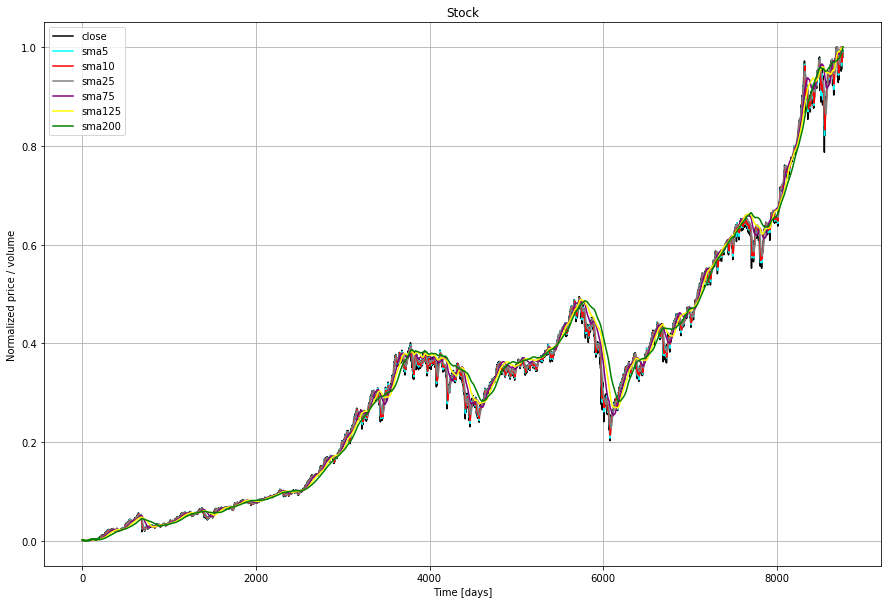

In [11]:
plt.figure(figsize=(15, 10))
plt.grid(True)
plt.plot(df_index_norm['Close'], color='black', label='close')
plt.plot(df_index_norm['sma5'], color='cyan', label='sma5')
plt.plot(df_index_norm['sma10'], color='red', label='sma10')
plt.plot(df_index_norm['sma25'], color='gray', label='sma25')
plt.plot(df_index_norm['sma75'], color='purple', label='sma75')
plt.plot(df_index_norm['sma125'], color='yellow', label='sma125')
plt.plot(df_index_norm['sma200'], color='green', label='sma200')
plt.title('Stock')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend(loc='best')
plt.show()

In [12]:
from tensorflow.keras import backend as K
K.clear_session()

In [29]:
from tensorflow.keras.layers import Bidirectional,TimeDistributed,BatchNormalization,Flatten,LeakyReLU

n_steps = seq_len - 1

def get_bi_gru():
    
    input1 = Input(shape=(19,10,))
    x = Bidirectional(LSTM(256, return_sequences=True))(input1)
    x = TimeDistributed(LeakyReLU())(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = LSTM(128)(x)
    x =(LeakyReLU())(x)
    x = (BatchNormalization())(x)
    out = Dense(10,activation='linear')(x)

    
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(0.005),
                loss='mse',
                metrics=['mse'])   
    
    return model

In [30]:
model = get_bi_gru()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 19, 10)]          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 19, 512)           546816    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 19, 512)           0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 19, 512)           2048      
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               328192    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512 

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
print('start training ')


weight_path_model = "saved_model/model_sma_NoVOL.h5"
callbacks_list_model = [
    ModelCheckpoint(
             weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=2
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.0001)
]

#################
batch_size = 256
epochs = 100
#################

history = model.fit(x_train, y_train, epochs=epochs, verbose=2, callbacks=callbacks_list_model,
          validation_data=(x_val, y_val),batch_size=batch_size) #batch_size=batch_size




start training 
Train on 6994 samples, validate on 874 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.20758, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 - 16s - loss: 0.3018 - mse: 0.3018 - val_loss: 0.2076 - val_mse: 0.2076
Epoch 2/100

Epoch 00002: val_loss improved from 0.20758 to 0.17097, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 - 10s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.1710 - val_mse: 0.1710
Epoch 3/100

Epoch 00003: val_loss improved from 0.17097 to 0.15423, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 - 10s - loss: 0.0030 - mse: 0.0030 - val_loss: 0.1542 - val_mse: 0.1542
Epoch 4/100

Epoch 00004: val_loss improved from 0.15423 to 0.12541, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 - 10s - loss: 0.0036 - mse: 0.0036 - val_loss: 0.1254 - val_mse: 0.1254
Epoch 5/100

Epoch 00005: val_loss improved from 0.12541 to 0.11579, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 - 10s - loss: 7.9698e-0

Epoch 45/100

Epoch 00045: val_loss did not improve from 0.00480
6994/6994 - 11s - loss: 2.2318e-04 - mse: 2.2318e-04 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 46/100

Epoch 00046: val_loss improved from 0.00480 to 0.00395, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 - 11s - loss: 1.7562e-04 - mse: 1.7562e-04 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 47/100

Epoch 00047: val_loss improved from 0.00395 to 0.00309, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 - 11s - loss: 2.0590e-04 - mse: 2.0590e-04 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 48/100

Epoch 00048: val_loss did not improve from 0.00309
6994/6994 - 11s - loss: 1.8658e-04 - mse: 1.8658e-04 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 49/100

Epoch 00049: val_loss did not improve from 0.00309
6994/6994 - 11s - loss: 1.2627e-04 - mse: 1.2627e-04 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 50/100

Epoch 00050: val_loss improved from 0.00309 to 0.00176, saving model to saved_model/model_sma_NoVOL.h5
6994

Epoch 93/100

Epoch 00093: val_loss did not improve from 0.00018
6994/6994 - 12s - loss: 1.4009e-04 - mse: 1.4009e-04 - val_loss: 3.4120e-04 - val_mse: 3.4120e-04
Epoch 94/100

Epoch 00094: val_loss did not improve from 0.00018
6994/6994 - 12s - loss: 1.8993e-04 - mse: 1.8993e-04 - val_loss: 2.8304e-04 - val_mse: 2.8304e-04
Epoch 95/100

Epoch 00095: val_loss did not improve from 0.00018
6994/6994 - 12s - loss: 1.0081e-04 - mse: 1.0081e-04 - val_loss: 2.6920e-04 - val_mse: 2.6920e-04
Epoch 96/100

Epoch 00096: val_loss did not improve from 0.00018
6994/6994 - 13s - loss: 9.4192e-05 - mse: 9.4192e-05 - val_loss: 2.4989e-04 - val_mse: 2.4989e-04
Epoch 97/100

Epoch 00097: val_loss did not improve from 0.00018
6994/6994 - 12s - loss: 9.6896e-05 - mse: 9.6896e-05 - val_loss: 2.2918e-04 - val_mse: 2.2918e-04
Epoch 98/100

Epoch 00098: val_loss did not improve from 0.00018
6994/6994 - 13s - loss: 9.8870e-05 - mse: 9.8870e-05 - val_loss: 2.6465e-04 - val_mse: 2.6465e-04
Epoch 99/100

Epoch 00

In [38]:
#from tensorflow.keras.models import load_model
#model = load_model("saved_model/model_sma_NoVOL.h5")


In [34]:
x_train.shape
y_train.shape

(6994, 10)

In [35]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [36]:
print(y_test_pred[0])

[0.68726885 0.6519897  0.64507264 0.66667    0.64014775 0.6309342
 0.65138775 0.6309867  0.63913035 0.65789175]


In [43]:
print( y_test_pred[:, 1][0])

0.6519897


In [53]:
def plot_compare(x):
    Col = {'Open':0, 'High':1, 'Low':2, 'Close':3, 'sma5':4, 'sma10':5, 'sma25':6, 'sma75':7, 'sma125':8, 'sma200':9}
    ft = Col[x]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')

    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_val.shape[0]), y_val[:, ft], 
             color='gray', label='val target')
    plt.plot(np.arange(y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft],
            color='red', label='train prediction') 
    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_val_pred.shape[0]),
            y_val_pred[:, ft], color='orange', label='val prediction')
    plt.plot(np.arange(y_train_pred.shape[0] + y_val_pred.shape[0],
            y_train_pred.shape[0] + y_val_pred.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color ='green', label='test prediction')
    plt.title('past and future stock price')
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color='green', label='test prediction')
    plt.title('future stock prices '+x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')



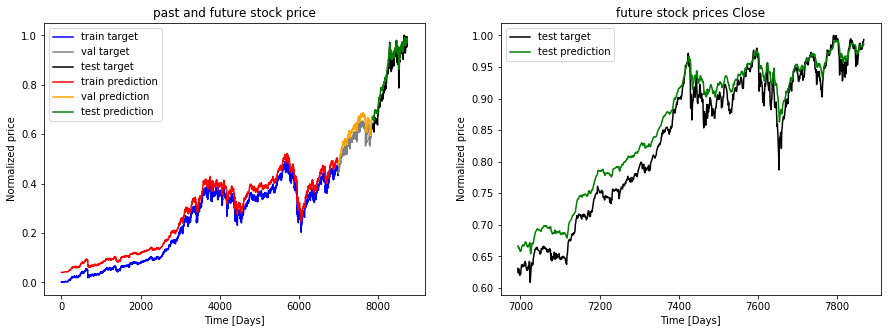

In [56]:
plot_compare('Close')